In [1]:
source("../../BrusselSprouts/scripts/functions.R")
crosses=readLines("~/data/trd/mapped_reads/TRD.vcf.gz.samples")
crosses=crosses[startsWith(crosses, "YJNRC")]
crosses


Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




[1] "YJNRC17" "YJNRC18" "YJNRC2"

In [2]:
i=2

In [3]:
sample=crosses[i]
sample

[1] "YJNRC18"

In [4]:
hetLoci=fread(paste0("~/data/trd/mapped_reads/",sample,".hetLoci.gz"))
colnames(hetLoci)=c("chr","pos","alleles","ADcross")
head(hetLoci)

,chr,pos,alleles,ADcross
,<chr>,<int>,<chr>,<chr>
1,chromosome1,111,"C,T","41,172"
2,chromosome1,136,"G,A","1,388"
3,chromosome1,305,"C,G","8,352"
4,chromosome1,349,"C,T","204,358"
5,chromosome1,396,"C,G","621,330"
6,chromosome1,461,"C,G","622,137"


In [5]:
head(hetLoci)
hetLoci$DPcross=NA
for(i in 1:nrow(hetLoci)){
    hetLoci$DPcross[i]=sum(as.numeric(strsplit(hetLoci$ADcross[i], ",", fixed=TRUE)[[1]]))
}

,chr,pos,alleles,ADcross
,<chr>,<int>,<chr>,<chr>
1,chromosome1,111,"C,T","41,172"
2,chromosome1,136,"G,A","1,388"
3,chromosome1,305,"C,G","8,352"
4,chromosome1,349,"C,T","204,358"
5,chromosome1,396,"C,G","621,330"
6,chromosome1,461,"C,G","622,137"


In [6]:
hetLoci=subset(hetLoci, DPcross <= quantile(DPcross, 0.95))
nrow(hetLoci)

[1] 72614

In [7]:
Crosses=readxl::read_xlsx("~/data/trd/Crosses.xlsx", sheet=2)
head(Crosses<-Crosses[,c("Cross ID","Short name 1","Short name 2")])

New names:
* `Is in Stock` -> `Is in Stock...4`
* `Is in Stock` -> `Is in Stock...6`


Cross ID,Short name 1,Short name 2
<chr>,<chr>,<chr>
YJNRC1,BAK,BET
YJNRC2,BAN,BTI
YJNRC3,AKH,BQC
YJNRC4,ABS,BEF
YJNRC5,BAK,BMK
YJNRC6,BAN,CRB


In [8]:
OH1=fread(paste0('/home/jnrunge/data/trd/mapped_reads/',Crosses$`Short name 1`[Crosses$`Cross ID`==sample],'.homLoci.gz'))
OH2=fread(paste0('/home/jnrunge/data/trd/mapped_reads/',Crosses$`Short name 2`[Crosses$`Cross ID`==sample],'.homLoci.gz'))

In [9]:
colnames(OH1)=c("chr","pos","alleles","GT1")
colnames(OH2)=c("chr","pos","alleles","GT2")
OH=full_join(OH1,OH2, by=c("chr","pos","alleles"))

OH=subset(OH, !is.na(GT1) & !is.na(GT2))
OH=subset(OH, substr(GT1,1,1) == substr(GT1,3,3))
OH=subset(OH, substr(GT2,1,1) == substr(GT2,3,3))
OH=subset(OH, substr(GT1,1,1) != substr(GT2,1,1))

In [10]:
OH_vs_cross=full_join(OH, hetLoci, by=c("chr","pos","alleles"))

if(sum(duplicated(OH_vs_cross[,c(1,2)]))>0){
    stop()
}
OH_vs_cross=subset(OH_vs_cross, !is.na(ADcross) & !is.na(GT1) & !is.na(GT2))
  if(nrow(OH_vs_cross)==0){
      df_fit$countLociFit[i]=0
      next
  } 

In [11]:
getAD=function(x){
    allele_count=str_count(OH_vs_cross$ADcross[x], ",")
    AD3_0=as.numeric(strsplit(OH_vs_cross$ADcross[x], ",", fixed=TRUE)[[1]][1])
    AD3_1=as.numeric(strsplit(OH_vs_cross$ADcross[x], ",", fixed=TRUE)[[1]][2])
    if(allele_count>1){
        AD3_2=as.numeric(strsplit(OH_vs_cross$ADcross[x], ",", fixed=TRUE)[[1]][3])
        if(allele_count>2){
            AD3_3=as.numeric(strsplit(OH_vs_cross$ADcross[x], ",", fixed=TRUE)[[1]][4])
        }else{
            AD3_3=NA
        }
    }else{
        AD3_2=NA
        AD3_3=NA
    }
    return(data.frame(AD3_0=AD3_0,AD3_1=AD3_1,AD3_2=AD3_2,AD3_3=AD3_3))
}

In [12]:
head(OH_vs_cross)

,chr,pos,alleles,GT1,GT2,ADcross,DPcross
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
3,chromosome1,13661,"A,G",1/1,0/0,"53,148",201
10,chromosome1,27729,"C,A",0/0,1|1,"92,159",251
11,chromosome1,27732,"G,T",0/0,1|1,"92,153",245
12,chromosome1,27738,"A,C",0/0,1|1,"81,148",229
13,chromosome1,27744,"T,C",0/0,1|1,"83,148",231
14,chromosome1,27747,"T,G,A",0/0,2|2,"81,0,144",225


In [13]:
isSNP=function(x){
    Alleles=OH_vs_cross$alleles[x]
    Alleles=strsplit(Alleles, ",", fixed=TRUE)[[1]]
    return(sum(str_length(Alleles)==1)==length(Alleles))
}

In [14]:
OH_vs_cross=OH_vs_cross[unlist(lapply(1:nrow(OH_vs_cross), isSNP)),]
OH_vs_cross=bind_cols(OH_vs_cross, bind_rows(lapply(1:nrow(OH_vs_cross), getAD)))
OH_vs_cross$Allele1=substr(OH_vs_cross$GT1, 1,1)
OH_vs_cross$Allele2=substr(OH_vs_cross$GT2, 1,1)


OH_vs_cross$AD_A1=NA
OH_vs_cross$AD_A2=NA

for(i in 1:nrow(OH_vs_cross)){
    OH_vs_cross$AD_A1[i]=OH_vs_cross[i, paste0("AD3_",OH_vs_cross$Allele1[i])]
    OH_vs_cross$AD_A2[i]=OH_vs_cross[i, paste0("AD3_",OH_vs_cross$Allele2[i])]
}

head(OH_vs_cross)

,chr,pos,alleles,GT1,GT2,ADcross,DPcross,AD3_0,AD3_1,AD3_2,AD3_3,Allele1,Allele2,AD_A1,AD_A2
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,chromosome1,13661,"A,G",1/1,0/0,"53,148",201,53,148,NA,NA,1,0,148,53
2,chromosome1,27729,"C,A",0/0,1|1,"92,159",251,92,159,NA,NA,0,1,92,159
3,chromosome1,27732,"G,T",0/0,1|1,"92,153",245,92,153,NA,NA,0,1,92,153
4,chromosome1,27738,"A,C",0/0,1|1,"81,148",229,81,148,NA,NA,0,1,81,148
5,chromosome1,27744,"T,C",0/0,1|1,"83,148",231,83,148,NA,NA,0,1,83,148
6,chromosome1,27747,"T,G,A",0/0,2|2,"81,0,144",225,81,0,144,NA,0,2,81,144


In [15]:
summary(OH_vs_cross$AD_A1-OH_vs_cross$AD_A2)

chrs=summarise(group_by(OH_vs_cross, chr),maxpos=max(pos))

OH_vs_cross$global_pos=OH_vs_cross$pos
for(c in 2:length(unique(OH_vs_cross$chr))){
    chr=unique(OH_vs_cross$chr)[c]
    OH_vs_cross$global_pos[OH_vs_cross$chr==chr]=OH_vs_cross$pos[OH_vs_cross$chr==chr]+sum(chrs$maxpos[chrs$chr%in%unique(OH_vs_cross$chr)[1:(c-1)]])
}
head(OH_vs_cross)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-221.00  -20.00   -1.00    4.63   18.00  345.00 

,chr,pos,alleles,GT1,GT2,ADcross,DPcross,AD3_0,AD3_1,AD3_2,AD3_3,Allele1,Allele2,AD_A1,AD_A2,global_pos
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
1,chromosome1,13661,"A,G",1/1,0/0,"53,148",201,53,148,NA,NA,1,0,148,53,13661
2,chromosome1,27729,"C,A",0/0,1|1,"92,159",251,92,159,NA,NA,0,1,92,159,27729
3,chromosome1,27732,"G,T",0/0,1|1,"92,153",245,92,153,NA,NA,0,1,92,153,27732
4,chromosome1,27738,"A,C",0/0,1|1,"81,148",229,81,148,NA,NA,0,1,81,148,27738
5,chromosome1,27744,"T,C",0/0,1|1,"83,148",231,83,148,NA,NA,0,1,83,148,27744
6,chromosome1,27747,"T,G,A",0/0,2|2,"81,0,144",225,81,0,144,NA,0,2,81,144,27747


In [16]:
chrs$global_pos=cumsum(chrs$maxpos)

In [17]:
OH_vs_cross$sumCount=OH_vs_cross$AD_A1+OH_vs_cross$AD_A2
OH_vs_cross=subset(OH_vs_cross, sumCount > 0)
OH_vs_cross=subset(OH_vs_cross, sumCount<=quantile(OH_vs_cross$sumCount, 0.95) & sumCount>=quantile(OH_vs_cross$sumCount, 0.05))

In [18]:
OH_vs_cross=subset(OH_vs_cross, (sumCount/DPcross) > 0.99)

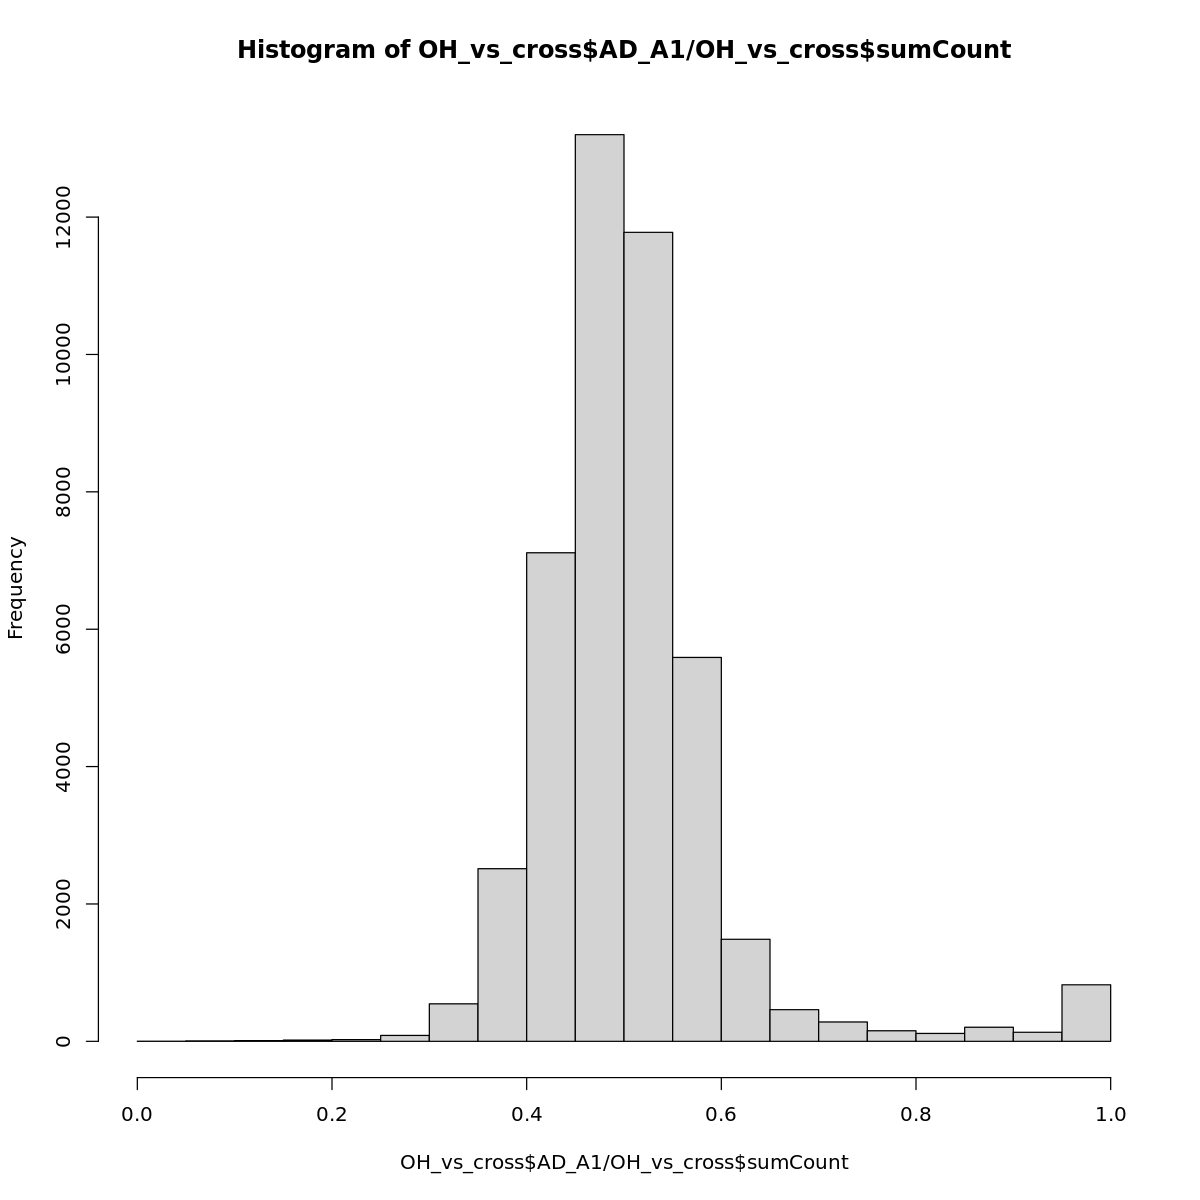

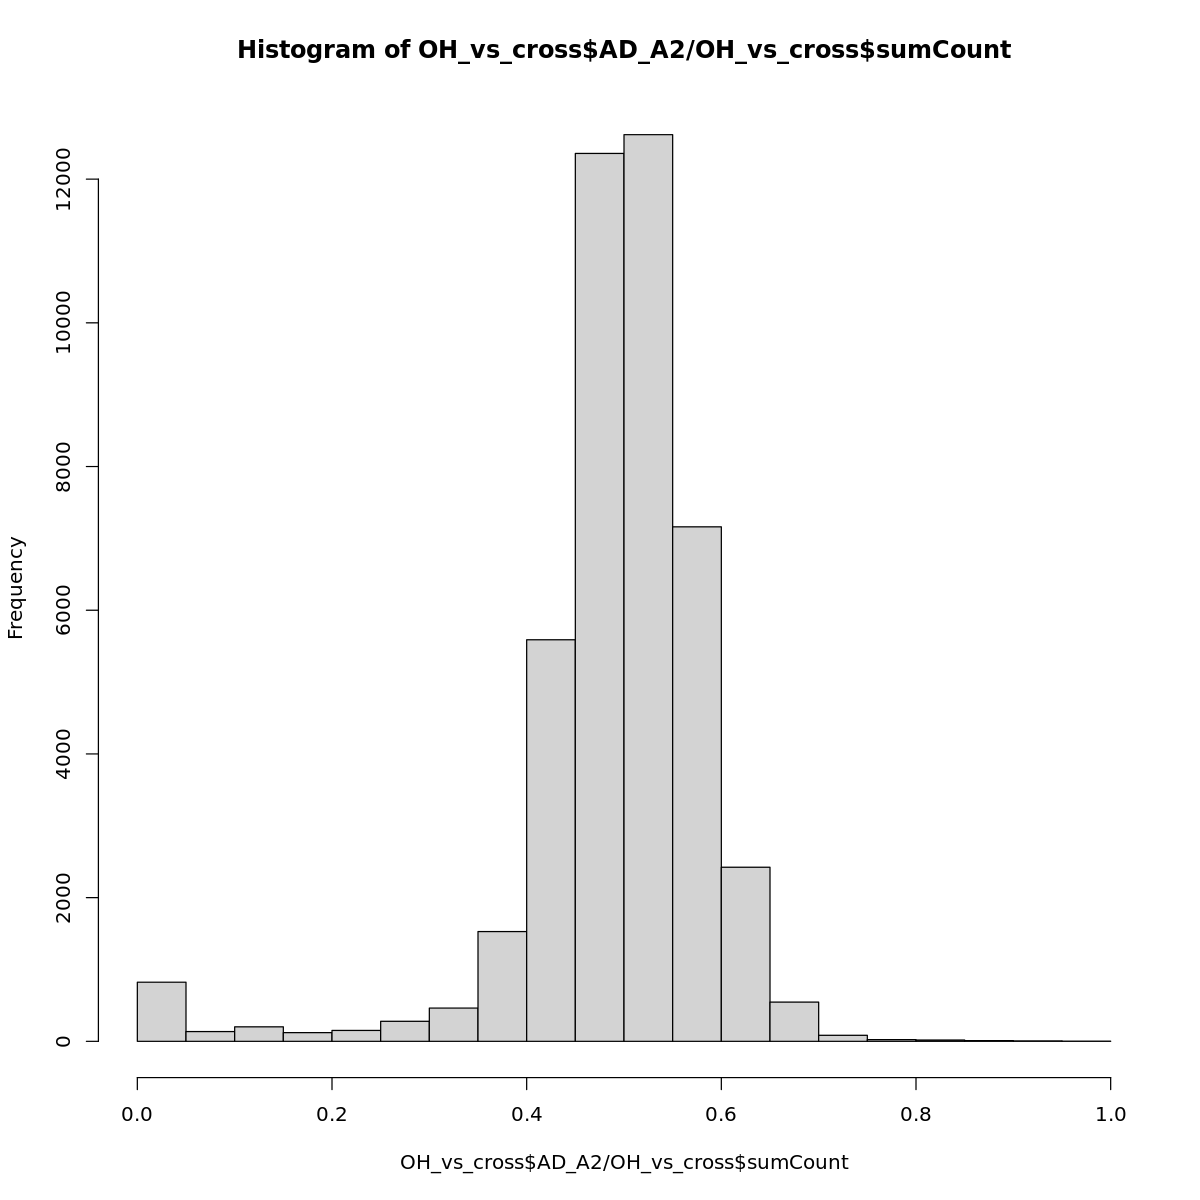

In [19]:
hist(OH_vs_cross$AD_A1/OH_vs_cross$sumCount)
hist(OH_vs_cross$AD_A2/OH_vs_cross$sumCount)

In [20]:
sum(OH_vs_cross$AD_A1==OH_vs_cross$sumCount) / nrow(OH_vs_cross)

[1] 0.0008755388

In [21]:
sum(OH_vs_cross$AD_A1!=OH_vs_cross$sumCount)
sum(OH_vs_cross$AD_A1==OH_vs_cross$sumCount)

[1] 44505

[1] 39

`geom_smooth()` using formula = 'y ~ x'


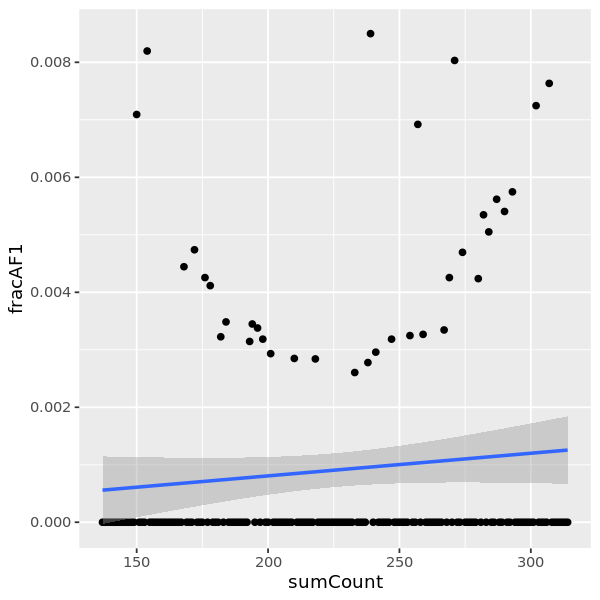

In [22]:
options(repr.plot.width=5, repr.plot.height=5)
data_summary_AF1=summarise(group_by(OH_vs_cross, sumCount), fracAF1=sum(AD_A1==sumCount)/n())
ggplot(data_summary_AF1, aes(sumCount,fracAF1))+
geom_point()+geom_smooth(method="lm")

In [23]:
mean(OH_vs_cross$AD_A1/OH_vs_cross$sumCount)

[1] 0.5083979

In [27]:
chr_summary=summarise(group_by(OH_vs_cross,chr), meanAF=mean(AD_A1/sumCount))

In [29]:
summary(lm((AD_A1/sumCount)~chr, OH_vs_cross))


Call:
lm(formula = (AD_A1/sumCount) ~ chr, data = OH_vs_cross)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.48368 -0.04786 -0.00724  0.03287  0.52744 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.494512   0.003095 159.777  < 2e-16 ***
chrchromosome10  0.056035   0.003527  15.889  < 2e-16 ***
chrchromosome11  0.003018   0.003474   0.869 0.384990    
chrchromosome12  0.007896   0.003419   2.309 0.020930 *  
chrchromosome13 -0.017022   0.003547  -4.799 1.60e-06 ***
chrchromosome14 -0.005414   0.003624  -1.494 0.135289    
chrchromosome15 -0.004075   0.003432  -1.187 0.235153    
chrchromosome16  0.058141   0.003533  16.458  < 2e-16 ***
chrchromosome2  -0.005817   0.003479  -1.672 0.094566 .  
chrchromosome3   0.003348   0.004702   0.712 0.476488    
chrchromosome4  -0.024455   0.003293  -7.427 1.13e-13 ***
chrchromosome5   0.182217   0.003754  48.541  < 2e-16 ***
chrchromosome6   0.015292   0.004098   3.731 0.000191 ***
chrch

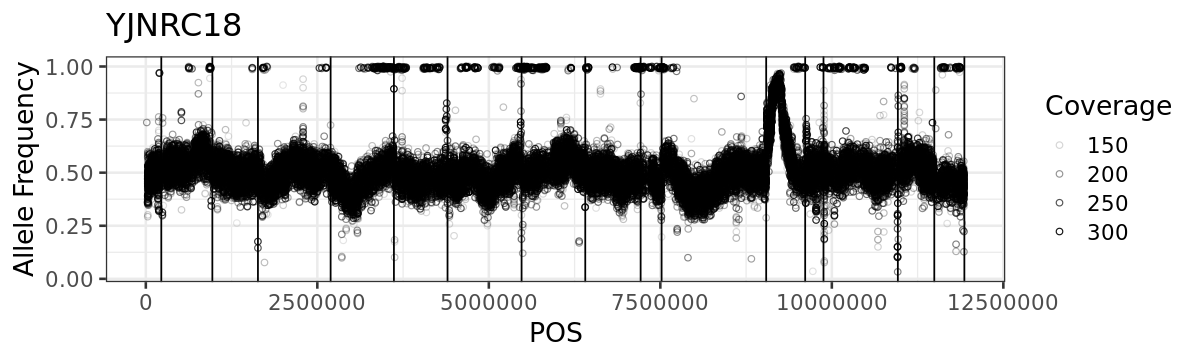

In [25]:
options(repr.plot.width=10, repr.plot.height=3)


print(ggplot(OH_vs_cross, aes(global_pos, AD_A1/sumCount, alpha=sumCount))+
geom_point(shape=1)+
geom_vline(xintercept = chrs$global_pos)+theme_bw(16)+ylab("Allele Frequency")+xlab("POS")+
ggtitle(sample)+labs(alpha="Coverage"))

In [ ]:
print(ggplot(OH_vs_cross, aes(global_pos, AD_A1/sumCount))+
geom_point(shape=1, alpha=0.1)+geom_smooth(method="loess")+
geom_vline(xintercept = chrs$global_pos)+theme_bw(16)+ylab("Allele Frequency")+xlab("POS")+
ggtitle(sample)+labs(alpha="Coverage"))

`geom_smooth()` using formula = 'y ~ x'


In [ ]:
loessMod50 <- loess((AD_A1/sumCount) ~ global_pos, data=OH_vs_cross, span=0.50)
head(loessMod50)

In [ ]:
smoothed50 <- predict(loessMod50) 

In [ ]:
head(smoothed50)

In [ ]:
print(ggplot(OH_vs_cross, aes(global_pos, AD_A1/sumCount))+
geom_point(shape=1, alpha=0.1)+geom_smooth(method="loess")+
geom_vline(xintercept = chrs$global_pos)+theme_bw(16)+ylab("Allele Frequency")+xlab("POS")+
ggtitle(sample)+labs(alpha="Coverage"))

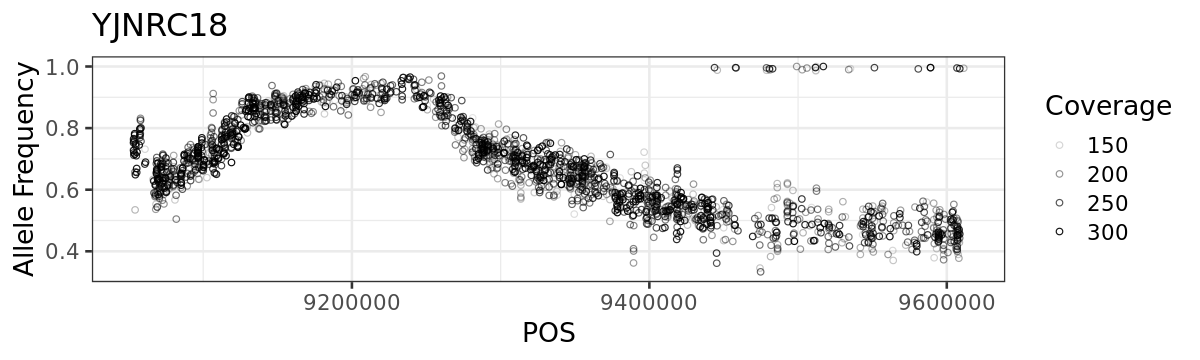

In [26]:
ggplot(subset(OH_vs_cross, chr=="chromosome5"), aes(global_pos, AD_A1/sumCount, alpha=sumCount))+
geom_point(shape=1)+
theme_bw(16)+ylab("Allele Frequency")+xlab("POS")+
ggtitle(sample)+labs(alpha="Coverage")